# 1. DATA LOAD

In [2]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt

def row_num(x=None): return pd.set_option('display.max_rows',x)
def col_num(x=None): return pd.set_option('display.max_columns',x)

row_num(10)
col_num(10)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df_raw = pd.read_csv('../../1_preprocessing/정제데이터/ready_dataset.csv', encoding='euc-kr')
df_ogwr = pd.read_csv('../../1_preprocessing/정제데이터/MGWR회귀계수/MGWR 회귀계수(평균영업기간,mm,data_1221).csv', encoding='euc-kr')
df_cluster = pd.read_csv('../군집화결과/12_4주차/f2_expo(total,mm,1222)).csv')

In [5]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   BAS_ID          158 non-null    int64
 1   open_7cluster   158 non-null    int64
 2   open_8cluster   158 non-null    int64
 3   open_9cluster   158 non-null    int64
 4   open_10cluster  158 non-null    int64
 5   open_11cluster  158 non-null    int64
 6   open_12cluster  158 non-null    int64
 7   open_13cluster  158 non-null    int64
 8   open_14cluster  158 non-null    int64
 9   open_15cluster  158 non-null    int64
 10  open_16cluster  158 non-null    int64
 11  open_17cluster  158 non-null    int64
 12  open_18cluster  158 non-null    int64
 13  open_19cluster  158 non-null    int64
 14  open_20cluster  158 non-null    int64
 15  open_21cluster  158 non-null    int64
 16  open_22cluster  158 non-null    int64
 17  open_23cluster  158 non-null    int64
 18  open_24cluster  158 non-null  

# 2. 군집과 회귀 계수에 대한 EDA

In [6]:
row_num(10)
# df_ocoef = pd.merge(df_ogwr, df_cluster[['BAS_ID','open_15cluster_sds']], on='BAS_ID', how='left')
cluster_col = 'open_15cluster'
df_ocoef = pd.merge(df_ogwr, df_cluster[['BAS_ID',cluster_col]], on='BAS_ID', how='left')
df_ocoef

,intercept,주거인구/직장인구,아파트 가구수,단독주택 비율,서비스업매출비율,...,상가밀도,x,y,BAS_ID,open_15cluster
0,101.621097,-19.987889,-16.801620,65.704605,14.014662,...,30.520389,126.689135,37.518708,21300,13
1,101.588382,-23.890852,-8.773298,62.139227,13.830890,...,29.879127,126.695459,37.522417,21301,2
2,101.522925,-25.789394,-5.523626,59.192299,13.568331,...,29.235275,126.701342,37.522339,21302,2
3,101.521680,-24.057234,-10.941299,61.390775,13.604052,...,29.536470,126.698730,37.518981,21303,2
4,101.489663,-25.927305,-8.067665,58.775076,13.453254,...,29.049711,126.703419,37.519319,21304,2
...,...,...,...,...,...,...,...,...,...,...,...
153,101.245787,21.224317,-24.982116,81.376537,13.441081,...,31.653166,126.692372,37.471208,21455,12
154,101.005612,-26.704756,-31.688316,74.597850,12.198783,...,30.076730,126.723687,37.476074,21456,1
155,100.869224,-43.321240,-53.173870,62.917525,11.516640,...,28.595270,126.749377,37.478546,21457,4
156,100.929799,-39.837053,-45.371749,66.149594,11.769030,...,29.259096,126.731154,37.483105,21458,4


In [7]:
row_num()
df_ocoef.isna().sum(axis=0)

intercept             0
주거인구/직장인구             0
아파트 가구수               0
단독주택 비율               0
서비스업매출비율              0
외식업매출비율               0
근린생활시설 비율             0
평균최근접역거리              0
(주거인구+직장인구) / 유동인구    0
공동주택 비율               0
평균 도로 길이              0
도로길이고려_전체통합도          0
평균최근접정류장거리            0
점포밀도                  0
도로율                   0
상가밀도                  0
x                     0
y                     0
BAS_ID                0
open_15cluster        0
dtype: int64

## 2.1. Boxplot으로 확인해 보기

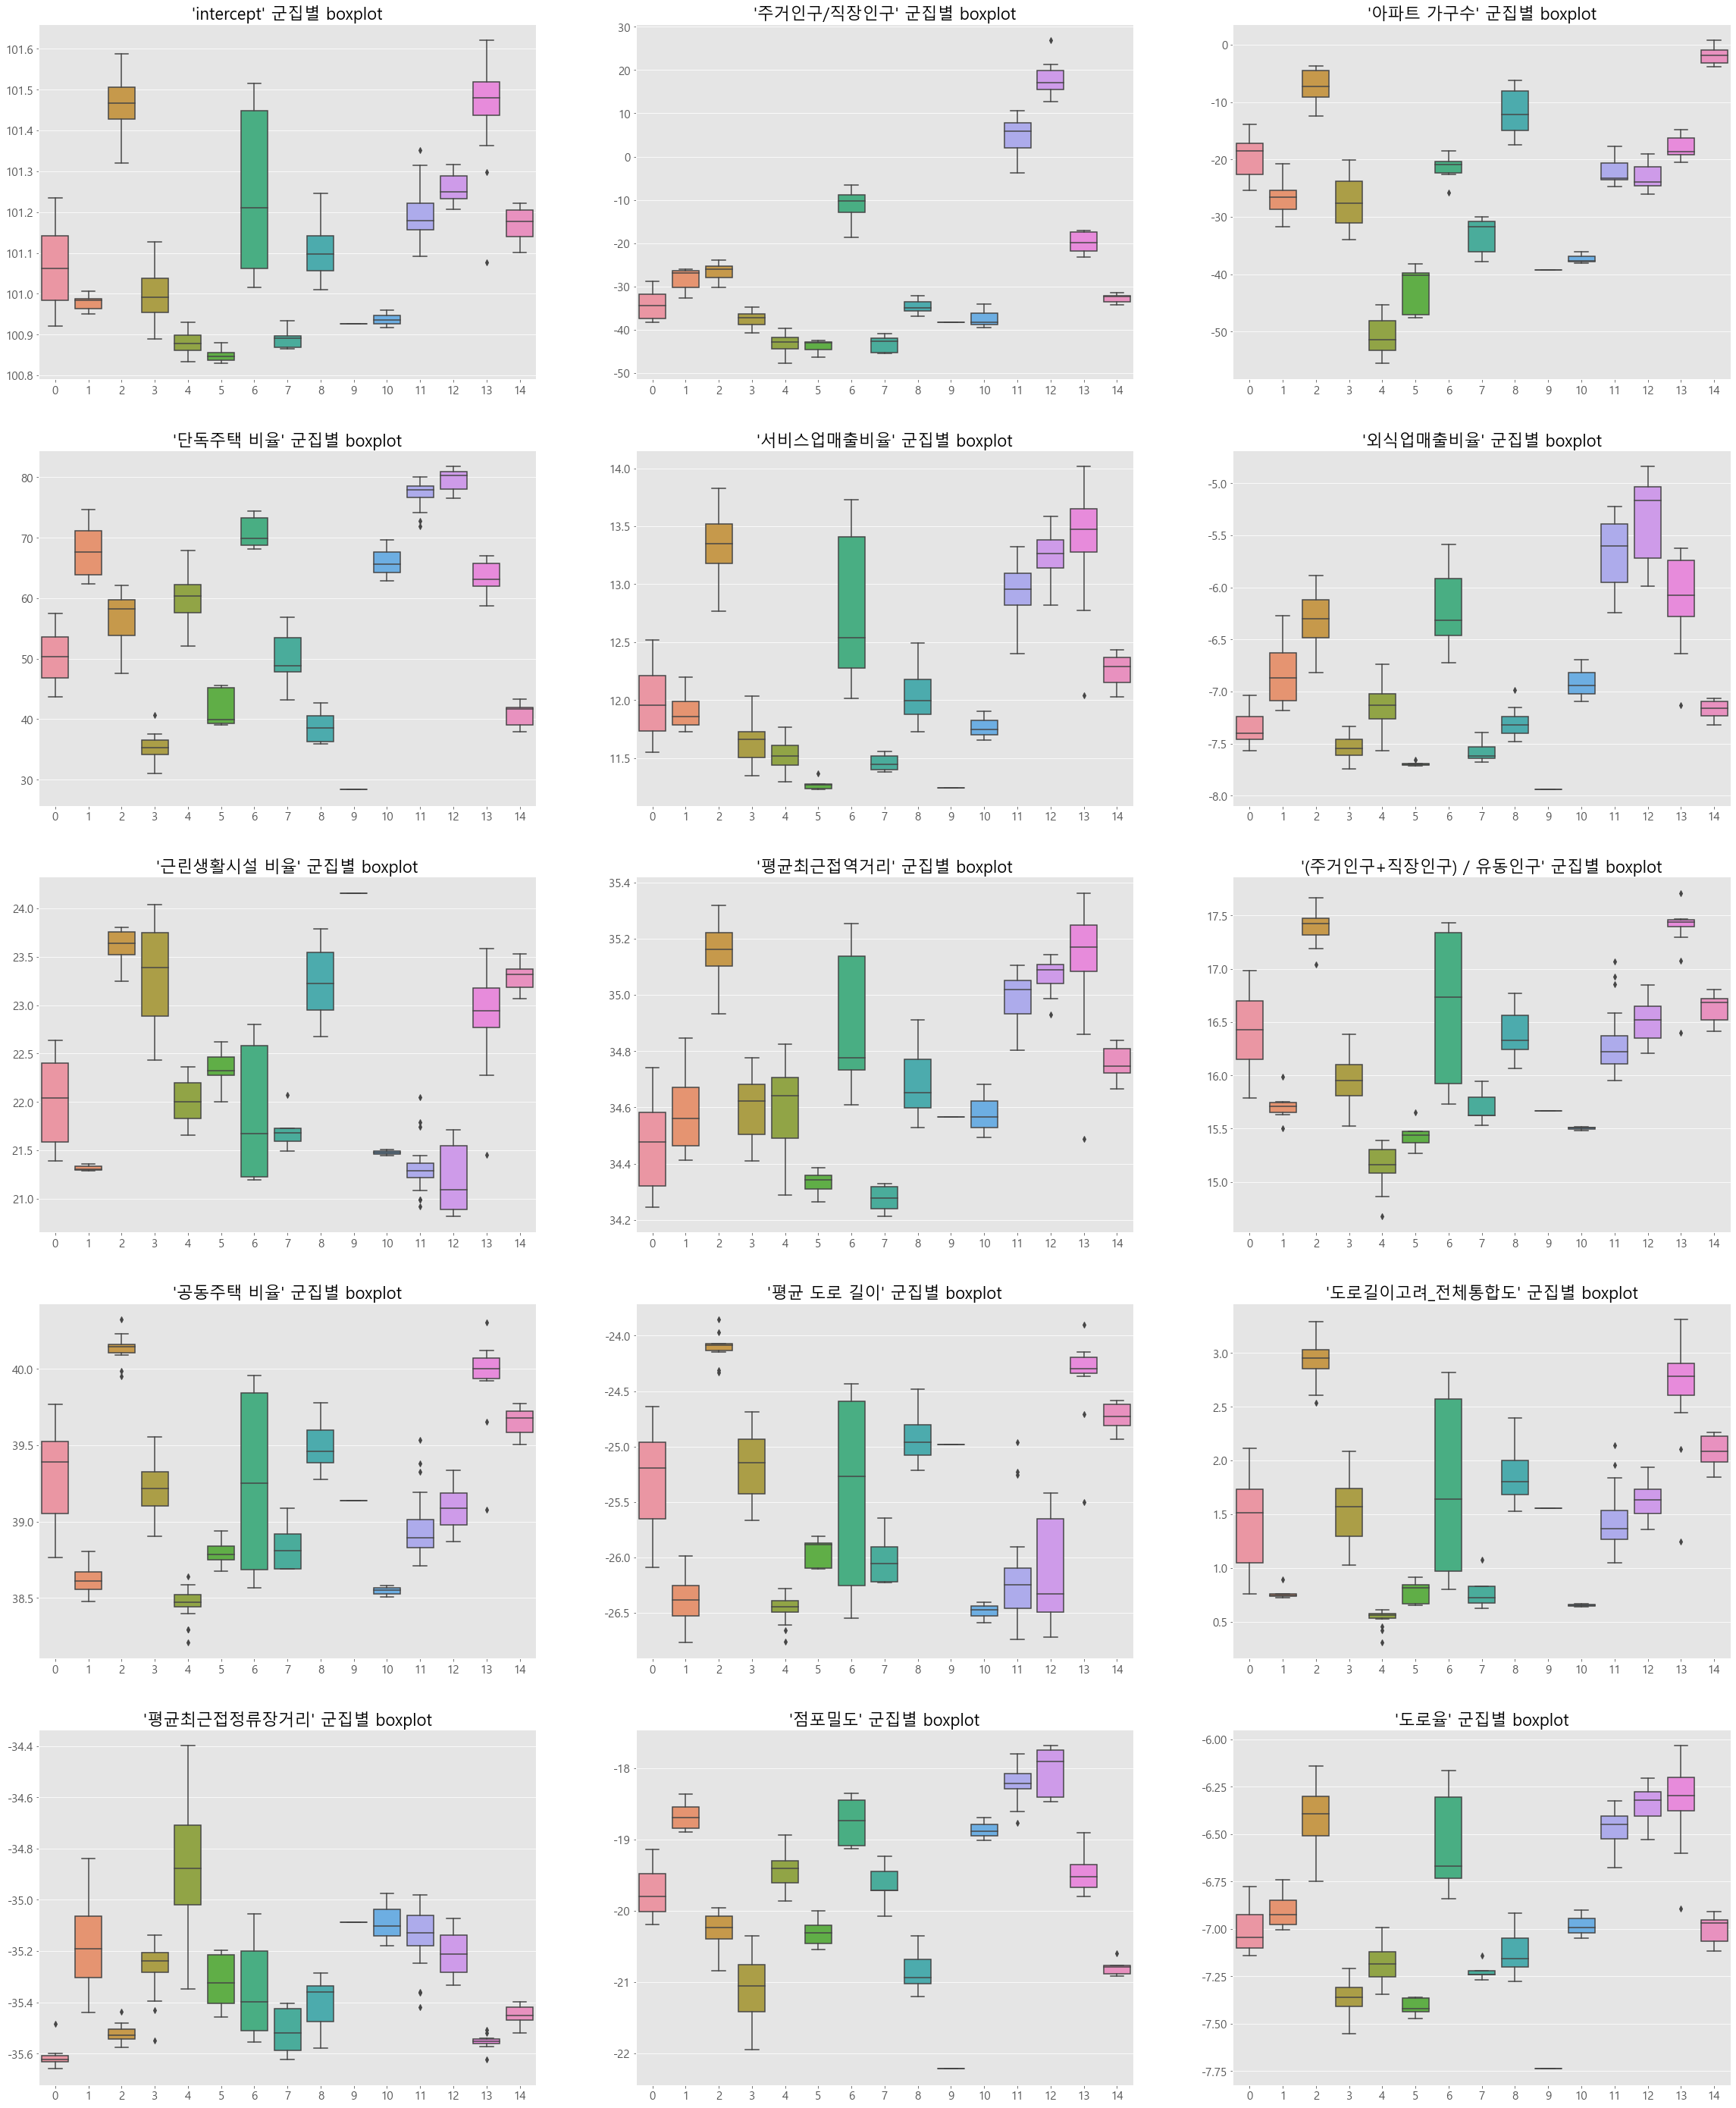

In [25]:
# 군집별 컬럼들의 boxplot 확인
import seaborn as sns

fig, ax = plt.subplots(5,3,figsize=(40,50))
col = 0
for i in range(0,5):
    for j in range(0,3):
    
        df_list = [df_ocoef.loc[df_ocoef[cluster_col]==k].iloc[:,col] for k in range(0,df_ocoef[cluster_col].max()+1)]
        
        
        # ax[i,j].boxplot(df_list)
        sns.boxplot(data=df_list, ax=ax[i,j])
        ax[i,j].set_title(f"'{df_ocoef.columns[col]}' 군집별 boxplot")
        col+=1
plt.show()

## 2.2 일원분산분석을 위한 조건 확인 절차

- 정규성 : Shapiro test
- 등분산성 : Levene test
- 독립성

### 2.2.1 정규성 - Shapiro
---
- 모든 그룹의 데이터는 정규성을 따라야 함

사실 정규성은 검정 해 볼 필요가 없다. 왜냐하면 일부 군집(6,8,9,10)의 관측값이 2~6개가 전부이기 때문에 정규성을 가정하기 굉장히 어렵다. 그럼에도 불구하고 shapiro test를 통해 정규성을 확인해 보자

In [9]:
from scipy.stats import shapiro
from tqdm import notebook


res_list=[]
for col in notebook.tqdm(df_ocoef.columns[:-4]):
    cluster_num, shapiro_stats, shapiro_pval, clust_len = [],[],[],[]
    
    # df_list = [df_ocoef.loc[df_ocoef[cluster_col]==0].loc[:,col], 
    #            df_ocoef.loc[df_ocoef[cluster_col]==1].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==2].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==3].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==4].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==5].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==6].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==7].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==8].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==9].loc[:,col],
    #            df_ocoef.loc[df_ocoef[cluster_col]==10].loc[:,col]]
    
    df_list = [df_ocoef.loc[df_ocoef[cluster_col]==i].loc[:,col] for i in range(0,df_ocoef[cluster_col].max()+1)]
    
    for cluster in range(0,len(df_list)):
        try:
            s_result = shapiro(df_list[cluster])
        #     print(f'Shapiro Result at {cluster} cluster : {s_result}')
            cluster_num.append(cluster)
            shapiro_stats.append(s_result[0])
            shapiro_pval.append(s_result[1])
            clust_len.append(len(df_ocoef.loc[df_ocoef[cluster_col]==cluster]))
        except:
            cluster_num.append(cluster)
            shapiro_stats.append(np.nan)
            shapiro_pval.append(np.nan)
            clust_len.append(len(df_ocoef.loc[df_ocoef[cluster_col]==cluster]))

    df_shapiro = pd.DataFrame([cluster_num, clust_len, shapiro_stats, shapiro_pval], index=['cluster','count','statistic','p_value']).T
    df_shapiro['reject'] = df_shapiro['p_value'] < .05
    df_shapiro['cluster'] = df_shapiro['cluster'].astype(int)
    df_shapiro['count'] = df_shapiro['count'].astype(int)
#     row_num(None)
#     print('='*50)
#     print('='*20+col+'='*20)
#     print('='*50)
#     print(df_shapiro)
#     print('='*50)
#     print('='*50)
#     print(f"result : {df_shapiro['reject'].any()}")
#     if df_shapiro['reject'].any()==False: print(col)
#     print()
    res_list.append([col, df_shapiro['reject'].any()])
# print(res_list)
df_shp_res = pd.DataFrame(res_list, columns=['coef_name','reject'])
df_shp_res

  0%|          | 0/16 [00:00<?, ?it/s]

,coef_name,reject
0,intercept,True
1,주거인구/직장인구,False
2,아파트 가구수,True
3,단독주택 비율,True
4,서비스업매출비율,False
5,외식업매출비율,False
6,근린생활시설 비율,True
7,평균최근접역거리,True
8,(주거인구+직장인구) / 유동인구,True
9,공동주택 비율,True


**정규성 검정 결과 Comment**
- Shapiro Test의 귀무가설 `H0:정규분포를 따른다` 
- `df_shapiro['reject'].any()`을 활용하여 하나의 군집이라도 정규성을 따르지 않는다면, True를 반환
- 결과 DataFrame을 살펴보면, 귀무가설이 채택되는 독립변수가 5개 밖에 없음<br><br>
$\therefore$ 정규성을 따른다고 할 수 없음

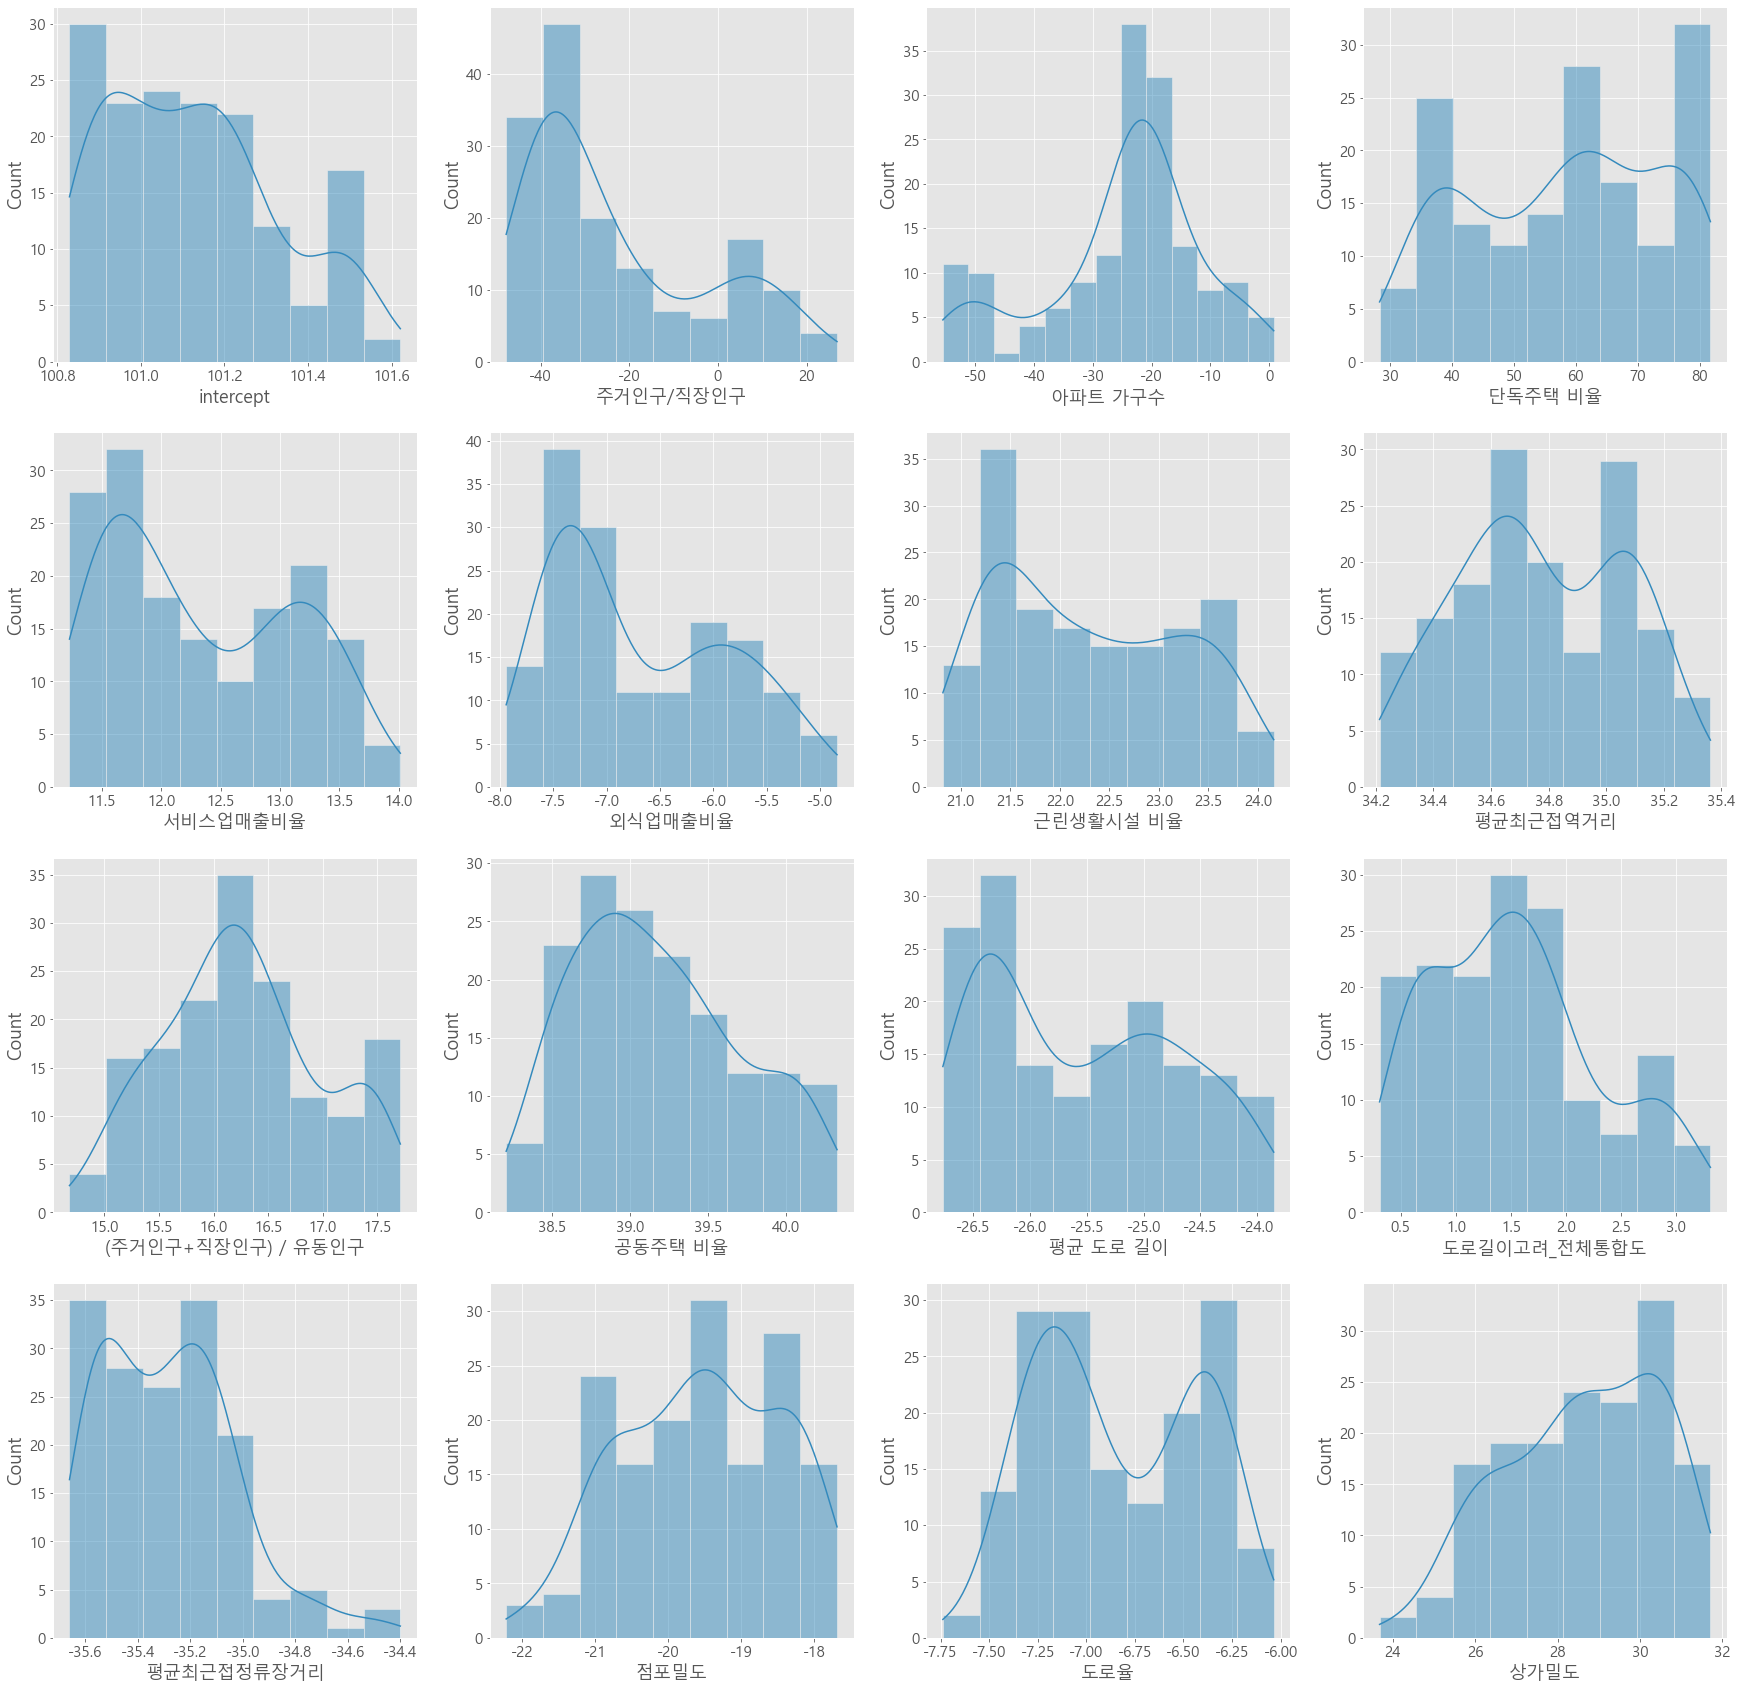

In [27]:
# + 추가로 확인해 보는 plot
import seaborn as sns

fig, ax = plt.subplots(4,4,figsize=(30,30))
col_num = 0
for i in range(0,4):
    for j in range(0,4):
        sns.histplot(ax=ax[i,j], x=df_ocoef.iloc[:,col_num], kde=True)
        col_num+=1
        # if col_num > 9:
        #     break
        # ax[i,j].set_title(df_ocoef.columns[col_num])
plt.show()
        

### 2.2.2 등분산성 - Levene
---
1. 가설설정<br>
${H_0}$ : $k$개의 집단에 대한 분산이 동일 $(\sigma_1=\sigma_2=\cdots=\sigma_k)$<br>
${H_1}$ : $k$개 중 하나라도 다른 분산이 존재

2. 검정통계량<br>
$W = {(N-k)\over(k-1)}\cdot{\sum_{i=1}^kN_i(Z_{i\cdot}-Z_{\cdot\cdot})^2 \over \sum_{i=1}^k\sum_{j=1}^{N_i}(Z_{ij}-Z_{i\cdot})^2}$  
$\vdots$  
$\vdots$

*이론은 나중에, $P-value < \alpha$ 면 기각 즉, 등분산이 아님*

In [11]:
a = [1,2,3,4,5,6,7,8,9]

def add_test(*args):
    res = 0
    for i in args:
        # print(i)
        res+=i
    return res
        

add_test(*(a))

45

In [12]:
df_ocoef.loc[df_ocoef[cluster_col]==13]

,intercept,주거인구/직장인구,아파트 가구수,단독주택 비율,서비스업매출비율,...,상가밀도,x,y,BAS_ID,open_15cluster
0,101.621097,-19.987889,-16.801620,65.704605,14.014662,...,30.520389,126.689135,37.518708,21300,13
6,101.519518,-22.203738,-15.008721,63.144727,13.628008,...,29.716398,126.697205,37.515679,21306,13
7,101.528663,-18.284907,-19.472992,66.135969,13.720454,...,30.220428,126.693100,37.512529,21307,13
8,101.520031,-17.418462,-20.271782,66.572152,13.691726,...,30.308971,126.694636,37.509724,21308,13
9,101.485862,-21.893767,-16.155360,62.601245,13.472991,...,29.605533,126.702572,37.510880,21309,13
13,101.453824,-23.152590,-14.797265,60.621244,13.319556,...,29.200186,126.706521,37.510598,21313,13
61,101.444278,-19.805296,-17.571698,62.622362,13.297909,...,29.446418,126.706259,37.507515,21361,13
62,101.436575,-17.222258,-18.672047,64.198601,13.280705,...,29.661308,126.706039,37.505429,21362,13
63,101.362837,-23.103526,-16.234099,58.684391,12.963909,...,28.909681,126.711726,37.505935,21363,13
67,101.510102,-17.014069,-20.547396,67.056291,13.654253,...,30.386286,126.696109,37.507611,21367,13


In [13]:
from scipy.stats import levene
import warnings

warnings.simplefilter('ignore')
col_res = []
for col in notebook.tqdm(df_ocoef.columns[:-4]):
    df_list = [df_ocoef.loc[df_ocoef[cluster_col]==i].loc[:,col].values for i in range(0,df_ocoef[cluster_col].max()+1)]
    result_lvn = levene(*df_list)
#     print(result_lvn)
    lvn_stats, lvn_pval = result_lvn[0], result_lvn[1]
    col_res.append([col, lvn_stats, lvn_pval])
df_lvn_res = pd.DataFrame(col_res, columns=['coefficient','statstics','p_value'])
df_lvn_res['reject'] = df_lvn_res['p_value'] < .05
df_lvn_res

  0%|          | 0/16 [00:00<?, ?it/s]

,coefficient,statstics,p_value,reject
0,intercept,6.415311,6.845345e-10,True
1,주거인구/직장인구,2.441448,4.139670e-03,True
2,아파트 가구수,1.881166,3.298314e-02,True
3,단독주택 비율,2.045587,1.828219e-02,True
4,서비스업매출비율,4.428626,1.514664e-06,True
5,외식업매출비율,3.921781,1.151918e-05,True
6,근린생활시설 비율,4.681637,5.539384e-07,True
7,평균최근접역거리,2.215901,9.741799e-03,True
8,(주거인구+직장인구) / 유동인구,5.191818,7.429196e-08,True
9,공동주택 비율,6.303667,1.041065e-09,True


**등분산 검정 결과 Comment**
- Levene Test의 귀무가설 `H0:k개의 집단의 분산이 동일` 
- 결과 DataFrame을 살펴보면, 귀무가설이 채택되는 독립변수는 1개 밖에 없음<br><br>
$\therefore$ 등분산성을 따른다고 할 수 없음

**==> 결과적으로 `일원분산분석`을 사용하는 것보다 비모수 군집간 검정인 `Kruskal Wallis H` 검정을 수행하여 유의성을 판단해야 함**

---

## 2.3 Kruskal Wallis H TEST

1. 가설 설정
    - $H_0$ : 모든 k개의 집단은 차이가 없다.
    - $H_1$ : 적어도 1개의 집단은 차이가 있다.
2. 결과 해석
    - $P-value < \alpha ,$ 귀무가설 기각 --> 적어도 1개의 집단은 다른 집단과 유의미한 차이가 있다.
    - $P-value > \alpha ,$ 귀무가설 채택 --> 모든 k개의 집단은 차이가 없다.
    

In [14]:
# 군집별 컬럼들의 krsukal 검정
from scipy.stats import kruskal

stat = []
pval = []

for i in range(0, len(df_ocoef.columns[:-4])):

    df_list = [df_ocoef.loc[df_ocoef[cluster_col]==k].iloc[:,i] for k in range(0,df_ocoef[cluster_col].max()+1)]
    
    h_result = kruskal(*df_list)
    stat.append(h_result[0])
    pval.append(h_result[1])

df_kruskal = pd.DataFrame(data = np.array([stat, pval]), 
                         columns = df_ocoef.columns[:-4],
                         index = ['statstics', 'p_value']).T
df_kruskal['Pr(t) < .01'] = df_kruskal['p_value'] < 0.01

In [15]:
row_num(None)
df_kruskal

,statstics,p_value,Pr(t) < .01
intercept,135.482002,5.595670e-22,True
주거인구/직장인구,151.454315,3.678077e-25,True
아파트 가구수,139.125890,1.058480e-22,True
단독주택 비율,149.291233,9.962530e-25,True
서비스업매출비율,136.537013,3.456664e-22,True
외식업매출비율,139.801274,7.770559e-23,True
근린생활시설 비율,130.432786,5.583248e-21,True
평균최근접역거리,122.493809,2.041433e-19,True
(주거인구+직장인구) / 유동인구,130.252466,6.060338e-21,True
공동주택 비율,128.146813,1.577479e-20,True


***----  K-W test 결과 해석  ----***

$\alpha = 0.01$ 일 때, 
- 모든 독립변수들에 대해 $P-value < \alpha$ 인 결과를 확인
- 즉, 모든 독립변수들에 대해 적어도 하나의 군집 이상은 다른 군집과의 유의미한 차이가 있음
- 구체적으로 어떤 집단에서 어떠한 차이가 있는지 알아보기 위해 사후분석 수행

---

## 2.3 비모수 검정의 사후분석

***--  Bonferroni Correction (본페르니 교정)  --***
1. 집단 간 차이에 대해 K-W test 수행
2. 집단 간 유의차가 있는 경우 각 집단 별 M-W test 수행
3. $\displaystyle{\alpha \over n}$으로 유의수준 교정 후 개별 집단 간 유의성 검정<br><br>

***--  Sidak Correction  --***
1. (BC Method와 동일)
2. (BC Method와 동일)
3. $\displaystyle{1-(1-\alpha)^{1 \over n}}$으로 유의수준 교정 후 개별 집단 간 유의성 검정

In [29]:
from itertools import combinations as comb
from scipy.stats import mannwhitneyu as mwtest

correction_res = dict()
cluster_comb = list(comb(range(0,df_ocoef[cluster_col].max()+1), 2))

df_list = [df_ocoef.loc[df_ocoef[cluster_col]==i] for i in range(0,df_ocoef[cluster_col].max()+1)]

for col in df_ocoef.columns[:-4]:
    result_mw = []
    for comb in cluster_comb:
        stats, pval = mwtest(df_list[comb[0]][col], df_list[comb[1]][col])
        result_mw.append([comb[0], comb[1], stats, pval])
    df_mw_res = pd.DataFrame(result_mw, columns=['group1', 'group2', 'statistics', 'p_value'])
    df_mw_res['group_set'] = [set([df_mw_res.loc[i,'group1'],df_mw_res.loc[i,'group2']]) for i in df_mw_res.index]
    df_mw_res['MW_reject'] = df_mw_res['p_value']<.05 # 유의 수준 .05로 검정
    df_mw_res['BC_reject'] = df_mw_res['p_value']<(.05/len(cluster_comb)) # Bonferroni Correction
    df_mw_res['SC_reject'] = df_mw_res['p_value']<(1-(1-.05)**(1/len(cluster_comb))) # Sidak Correction
    correction_res[col] = df_mw_res

In [30]:
print(f'Bonferroni Correction alpha-adj : {.05/len(cluster_comb)}')
print(f'Sidak Correction alpha-adj : {1-(1-.05)**(1/len(cluster_comb))}')

Bonferroni Correction alpha-adj : 0.0004761904761904762
Sidak Correction alpha-adj : 0.0004883882652020333


In [18]:
print_col_list = ['group1','group2','statistics','p_value',
                  'MW_reject', 'BC_reject', 'SC_reject']
for key in correction_res.keys():
    print('='*40,key,'='*40)
    print(correction_res[key][print_col_list])
    print('='*90)
    print()

======================================== intercept ========================================
     group1  group2  statistics       p_value  MW_reject  BC_reject  SC_reject
0         0       1        55.0  8.306399e-02      False      False      False
1         0       2         0.0  5.548186e-05       True       True       True
2         0       3       147.0  1.031364e-01      False      False      False
3         0       4       238.0  4.792286e-06       True       True       True
4         0       5        60.0  3.232062e-04       True       True       True
5         0       6        25.0  4.282561e-02       True      False      False
6         0       7        58.0  1.292825e-03       True      False      False
7         0       8        51.0  2.365841e-01      False      False      False
8         0       9        10.0  4.615385e-01      False      False      False
9         0      10        31.0  7.032967e-02      False      False      False
10        0      11        40.0  3.8137

# 3. 사후분석의 결과 분석

## 3.1 Correction 결과를 군집별로 정리 / P-value Heatmap

In [32]:
# P-value 결과정리
correction_convert_dict = dict()
for cluster in range(0,df_ocoef[cluster_col].max()+1):
    df_cluster = pd.DataFrame([])
    for key in correction_res.keys():
        df_temp = correction_res[key]
        df_temp['IS_IN'] = df_temp['group_set'].apply(lambda x: cluster in x)
        df_use = df_temp.loc[df_temp['IS_IN']]
        idx_list = df_use['group_set'].apply(lambda x: list(x.difference({cluster})).pop())
        df_cluster['cluster'] = idx_list
        df_cluster[key] = df_use['p_value'].values
    correction_convert_dict[cluster] = df_cluster.reset_index(drop=True)

In [37]:
correction_convert_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

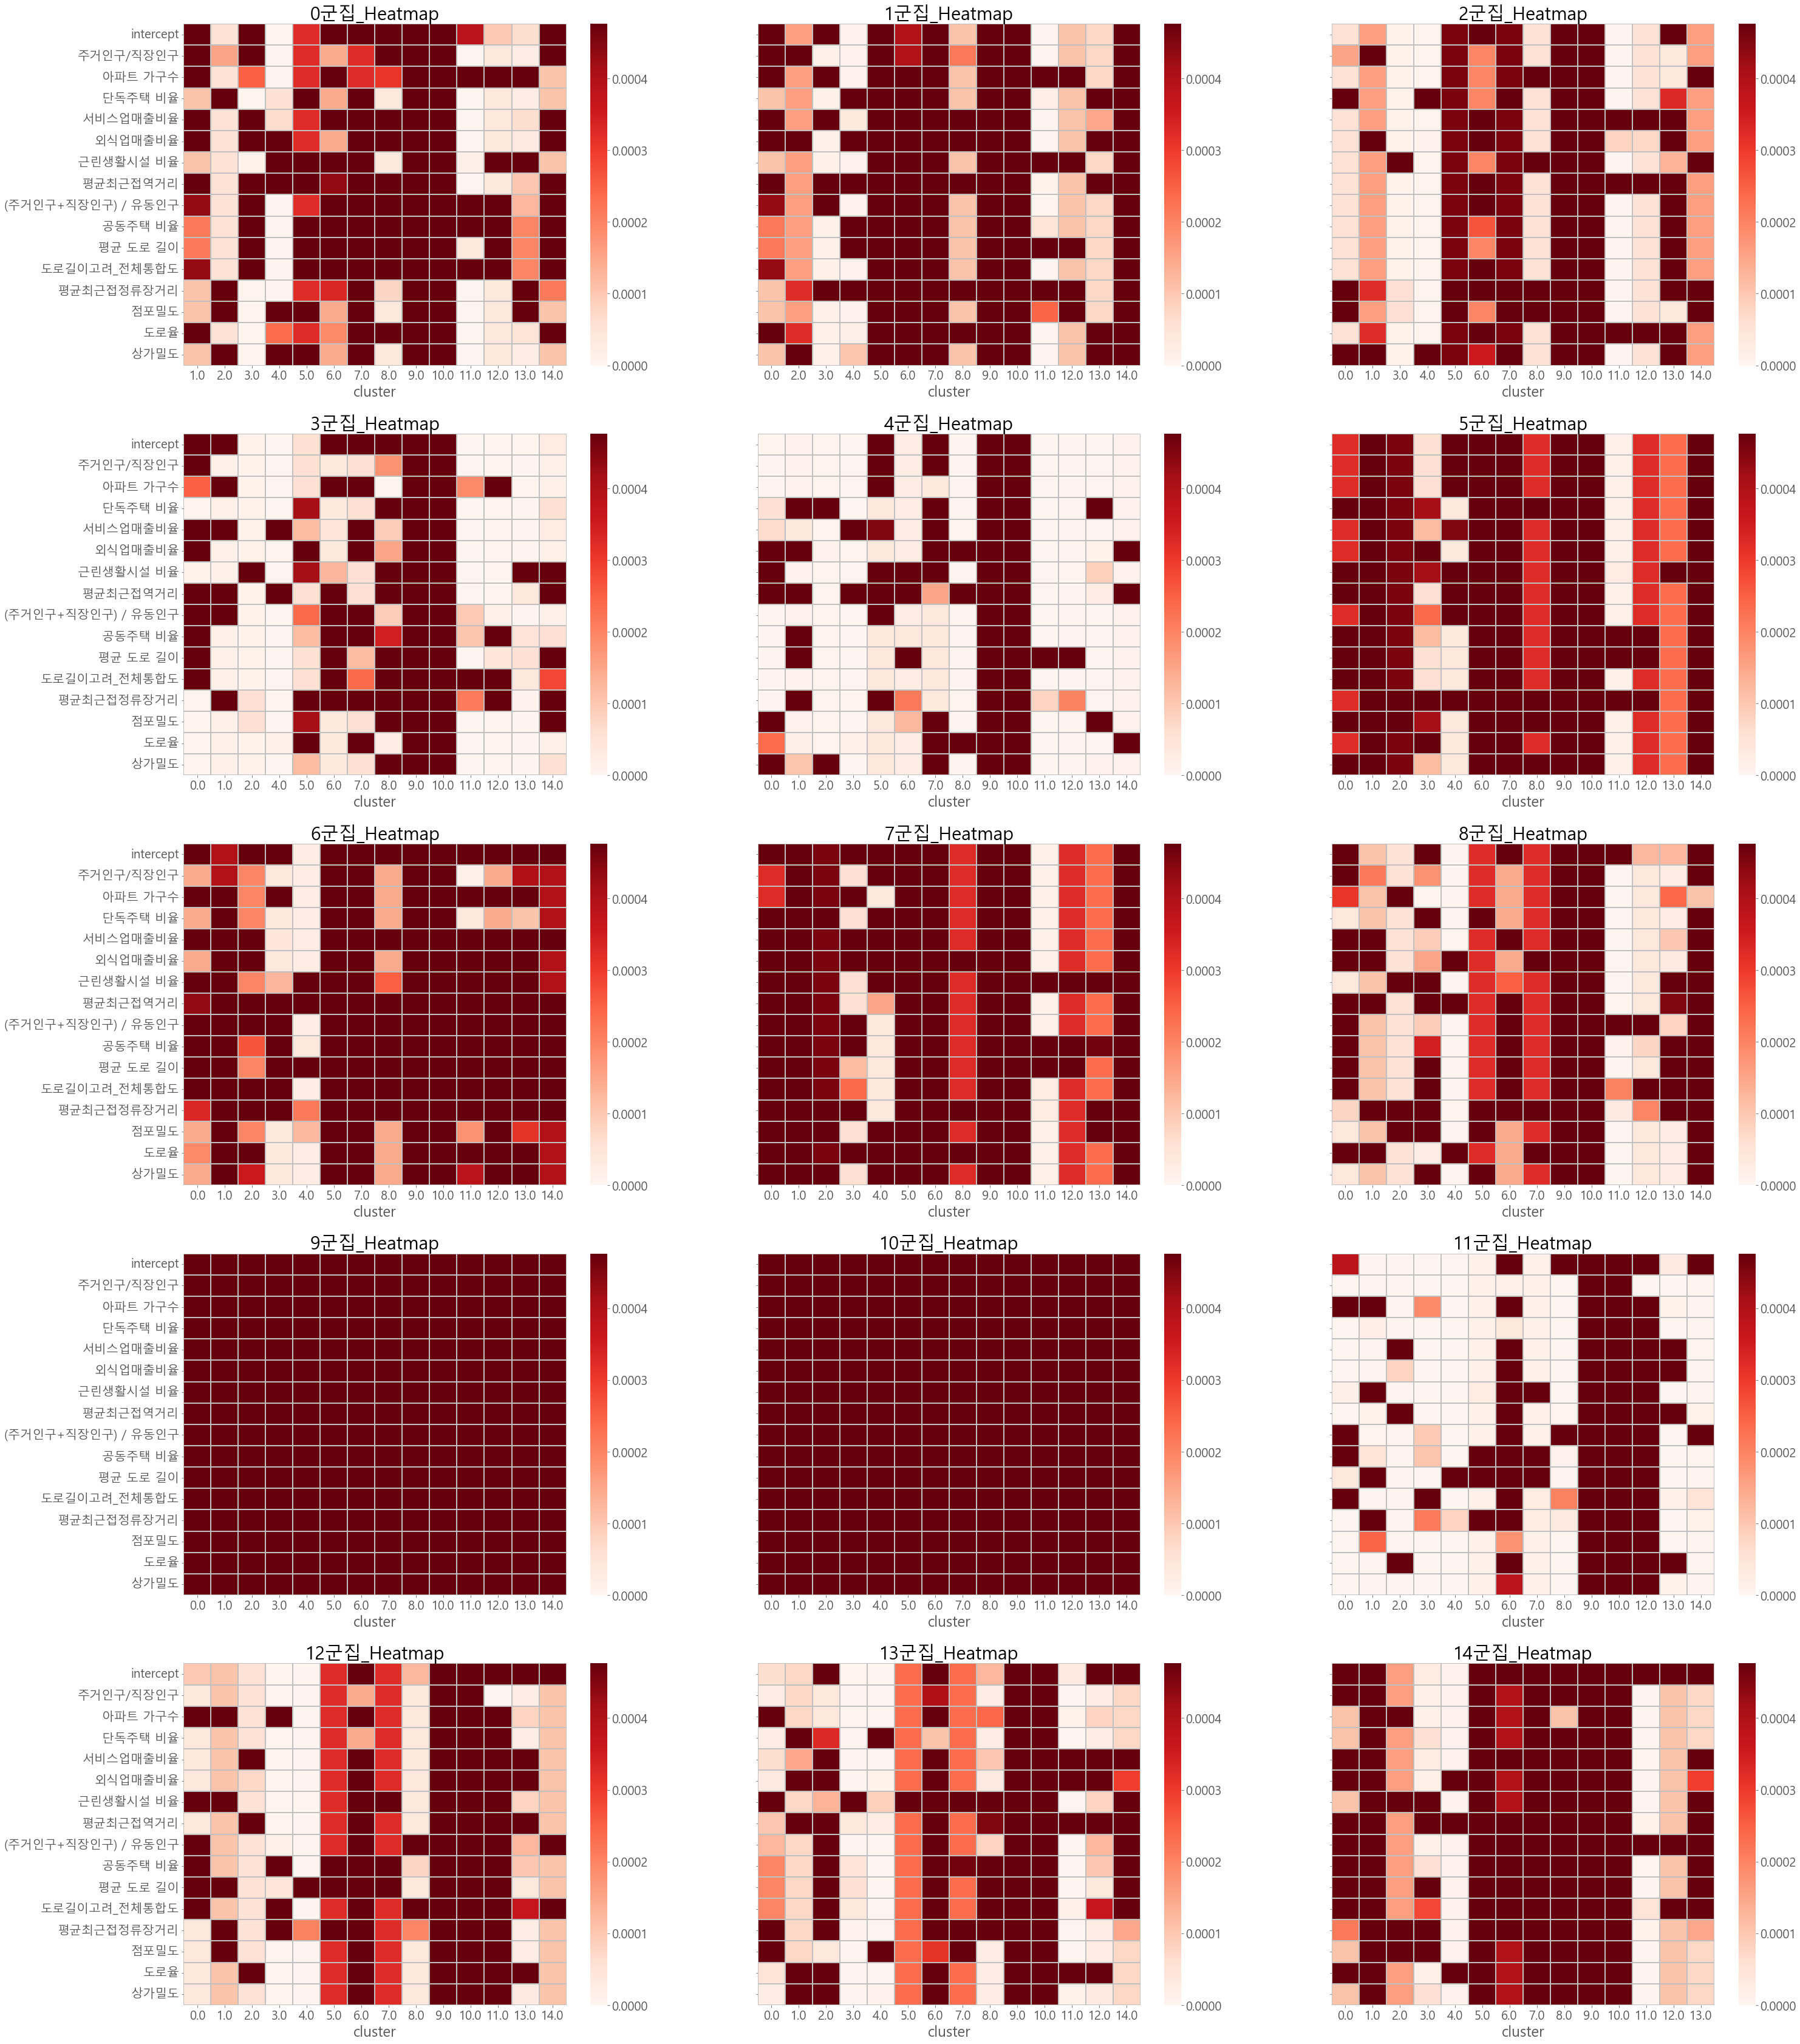

In [54]:
import seaborn as sns

# plt.rcParams['figure.figsize'] = (30,20)
plt.rcParams['font.size'] = 20
key=0
fig, ax = plt.subplots(5,3,sharey=True,squeeze=True,figsize=(48,60))
for i in range(0,5):    
    for j in range(0,3):
        df_temp = correction_convert_dict[key].T
        df_temp.columns = df_temp.loc['cluster',:]
        df_temp.drop('cluster', axis=0, inplace=True)
        sns.heatmap(df_temp,
                    linecolor='silver',
                    # annot=True,
                    linewidth = 0.05,
                    vmax = .05/len(cluster_comb),
                    vmin = 0,
                    # square=True,
                    cmap='Reds',
                    ax=ax[i,j]
                    )
        # plt.title(str(key)+'군집_Heatmap', size=30)
        ax[i,j].set_title(str(key)+'군집_Heatmap', size=30)
        key+=1

plt.show()